               crash_date traffic_control_device weather_condition  \
0  07/29/2023 01:00:00 PM         TRAFFIC SIGNAL             CLEAR   
1  08/13/2023 12:11:00 AM         TRAFFIC SIGNAL             CLEAR   
2  12/09/2021 10:30:00 AM         TRAFFIC SIGNAL             CLEAR   
3  08/09/2023 07:55:00 PM         TRAFFIC SIGNAL             CLEAR   
4  08/19/2023 02:55:00 PM         TRAFFIC SIGNAL             CLEAR   

       lighting_condition first_crash_type trafficway_type  \
0                DAYLIGHT          TURNING     NOT DIVIDED   
1  DARKNESS, LIGHTED ROAD          TURNING        FOUR WAY   
2                DAYLIGHT         REAR END  T-INTERSECTION   
3                DAYLIGHT            ANGLE        FOUR WAY   
4                DAYLIGHT         REAR END  T-INTERSECTION   

            alignment roadway_surface_cond road_defect  \
0  STRAIGHT AND LEVEL              UNKNOWN     UNKNOWN   
1  STRAIGHT AND LEVEL                  DRY  NO DEFECTS   
2  STRAIGHT AND LEVEL           

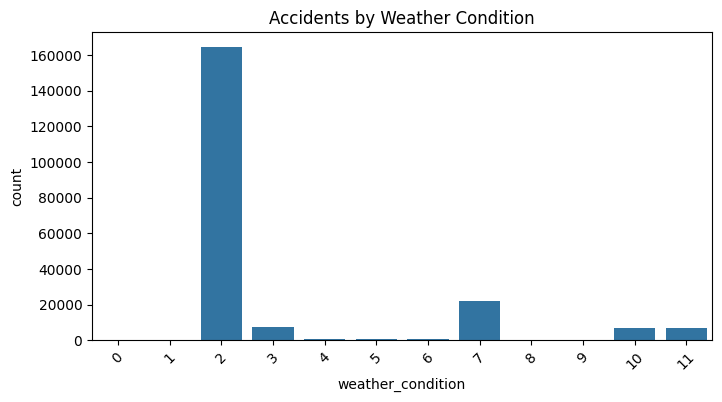

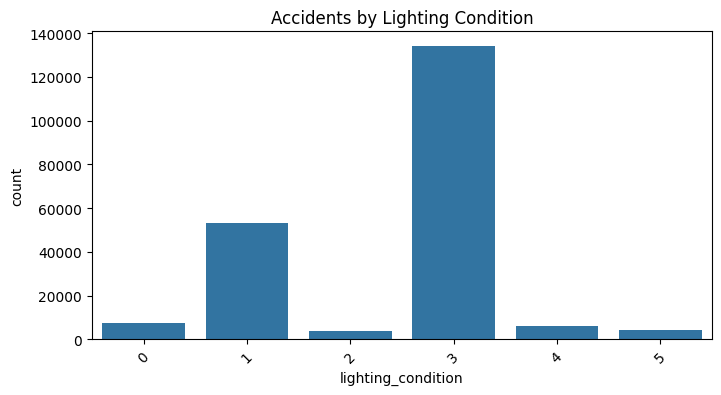

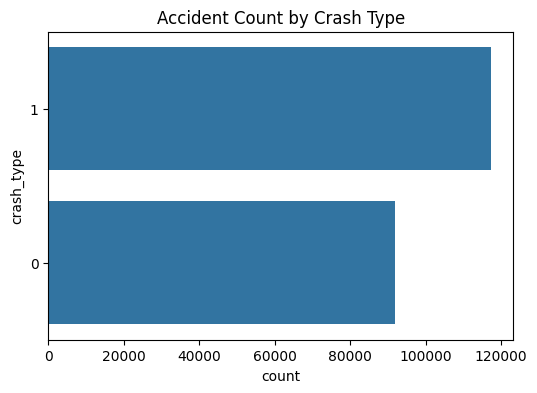

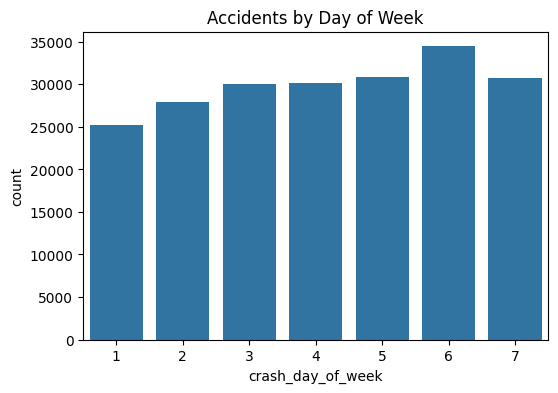

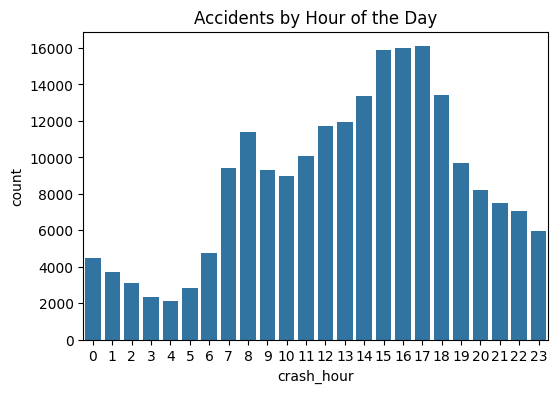

Model Accuracy: 74.22%


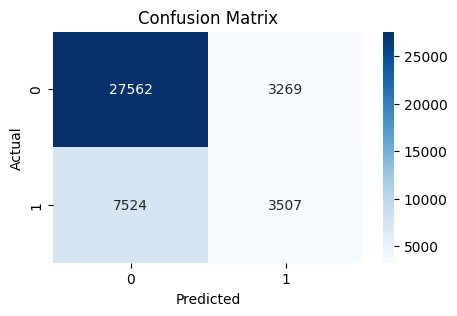

              precision    recall  f1-score   support

           0       0.79      0.89      0.84     30831
           1       0.52      0.32      0.39     11031

    accuracy                           0.74     41862
   macro avg       0.65      0.61      0.62     41862
weighted avg       0.71      0.74      0.72     41862



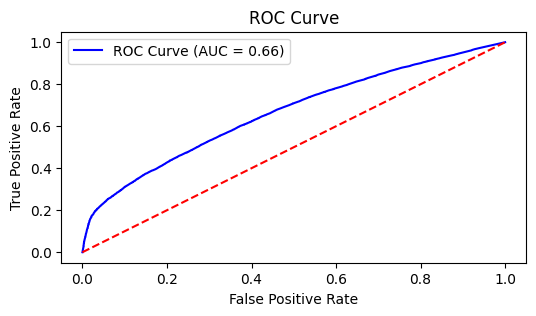

                   Feature  Importance
8               crash_hour    0.218152
3         first_crash_type    0.213696
10             crash_month    0.174830
9        crash_day_of_week    0.137048
4          trafficway_type    0.073478
0   traffic_control_device    0.050384
2       lighting_condition    0.036799
1        weather_condition    0.033888
6     roadway_surface_cond    0.025405
7              road_defect    0.025293
5                alignment    0.011026


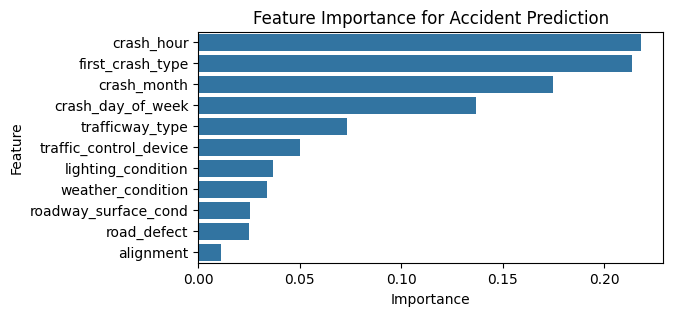

In [6]:
# -----------------------------
# SMART TRAFFIC ACCIDENT PREDICTION SYSTEM
# -----------------------------

# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 2. Load Dataset
# -----------------------------
data = pd.read_csv("traffic_accidents.csv")  # Replace with your dataset path

# Preview data
print(data.head())
print(data.columns)

# -----------------------------
# 3. Data Preprocessing
# -----------------------------
# Drop missing values
data = data.dropna()

# Convert categorical variables to numeric
categorical_features = [
    'traffic_control_device', 'weather_condition', 'lighting_condition',
    'first_crash_type', 'trafficway_type', 'alignment', 'roadway_surface_cond',
    'road_defect', 'crash_type', 'most_severe_injury'
]

for col in categorical_features:
    if col in data.columns:
        data[col] = data[col].astype('category').cat.codes

# Create target variable: 1 if injuries_total > 0, else 0
data['accident_occurred'] = data['injuries_total'].apply(lambda x: 1 if x > 0 else 0)

# Define features and target
features = [
    'traffic_control_device', 'weather_condition', 'lighting_condition',
    'first_crash_type', 'trafficway_type', 'alignment', 'roadway_surface_cond',
    'road_defect', 'crash_hour', 'crash_day_of_week', 'crash_month'
]

X = data[features]
y = data['accident_occurred']

# -----------------------------
# 4. Exploratory Data Analysis (EDA)
# -----------------------------
plt.figure(figsize=(8,4))
sns.countplot(x='weather_condition', data=data)
plt.title("Accidents by Weather Condition")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8,4))
sns.countplot(x='lighting_condition', data=data)
plt.title("Accidents by Lighting Condition")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(y='crash_type', data=data, order=data['crash_type'].value_counts().index)
plt.title("Accident Count by Crash Type")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='crash_day_of_week', data=data)
plt.title("Accidents by Day of Week")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='crash_hour', data=data)
plt.title("Accidents by Hour of the Day")
plt.show()

# -----------------------------
# 5. Split Data into Train/Test
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------
# 6. Model Training
# -----------------------------
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# -----------------------------
# 7. Prediction
# -----------------------------
y_pred = model.predict(X_test)

# -----------------------------
# 8. Model Evaluation
# -----------------------------
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))

# -----------------------------
# 9. ROC Curve
# -----------------------------
y_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,3))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# -----------------------------
# 10. Feature Importance
# -----------------------------
feature_importances = pd.DataFrame({'Feature': features, 'Importance': model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

plt.figure(figsize=(6,3))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title("Feature Importance for Accident Prediction")
plt.show()

# -----------------------------
# 11. Spatial / Map Visualization (Optional)
# -----------------------------
if 'latitude' in data.columns and 'longitude' in data.columns:
    plt.figure(figsize=(6,3))
    scatter_data = X_test.copy()
    scatter_data['Predicted'] = y_pred
    sns.scatterplot(
        x='longitude', y='latitude', hue='Predicted', data=scatter_data, palette='coolwarm', alpha=0.6
    )
    plt.title("Predicted Accident-Prone Areas")
    plt.show()

    # Density heatmap
    plt.figure(figsize=(10,6))
    sns.kdeplot(
        x=data['longitude'], y=data['latitude'], fill=True, cmap='Reds', bw_adjust=0.5
    )
    plt.title("Accident Density Heatmap")
    plt.show()
